In [6]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb
import pandas as pd
import matplotlib.pyplot as plt

## Background

In this blog post I'm going to share my initial experiments as I try to get on the [imagenette leaderboard](https://github.com/fastai/imagenette).

> Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

This exercise is a bit of a detour but related to my [TinyScaleLab project](https://vishalbakshi.github.io/blog/posts/2025-04-26-TinyScale-Lab-Kickoff/) in which I'm trying to analyze the relationship between downstream capabilities and training dynamics for tiny language models (5M-125M) trained on the TinyStories dataset.

I was running some initial rough 1 epoch training runs with my 5M architecture to find the best batch size for training efficiency (memory usage and training speed). I encountered a peculiar result which was counterintuitive to me:

|Metric|bs=64|256|1024|2048|4096
|:-|:-|:-|:-|:-|:-|
|Time|3hr |1hr|0.5hr|0.5hr|OOM
|Train loss|3.58|3.46|4.42|5.57|OOM
|Eval loss|3.58|3.46|4.43|5.57|OOM

I was expecting that increase the batch size would:

1. speed up training
2. decrease loss

However, increasing batch size from 1024 to 2048 did not speed up training, and increasing batch size from 256 to 2048 did not improve the loss. As always, when I run into something unexpected, I post it on Twitter. I received a number of insightful comments:


<blockquote class="twitter-tweet"><p lang="en" dir="ltr">We covered this in some of our earlier courses - lower batch sizes provide more updates, which should give better results for a fixed # epochs.</p>&mdash; Jeremy Howard (@jeremyphoward) <a href="https://twitter.com/jeremyphoward/status/1927192030335132090?ref_src=twsrc%5Etfw">May 27, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

The batch size of 256 was certainly providing more updates in one epoch than a batch size of 1024 or 2048. It's interesting to note that a batch size of 64, even though providing 4x the number of updates as 256, had a higher loss at the end of the epoch. It's important to note that I did not measure downstream performance for this experiment.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">TinyStories is a pretty homogeneous dataset, so one doesn&#39;t need as large of a batch size to achieve a smooth gradient compared to a more diverse pretraining dataset.<br><br>You&#39;ll want to set the batch size balancing speed and performance.</p>&mdash; Benjamin Warner (@benjamin_warner) <a href="https://twitter.com/benjamin_warner/status/1927194448389169190?ref_src=twsrc%5Etfw">May 27, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

This was another interesting point. The benefit of increasing batch size is to get a closer representation to the overall dataset. Since the TinyStories dataset is quite homogenous (all dataset items are children's stories) a smaller batch size will be sufficiently representative of the full dataset. On the flip side, if we have a dataset like the PETS dataset, and used a small batch size of say 32, we could imagine a scenario where the batch only includes images of a single class. The model, which has been learning about a diverse set of animals to this point will perform poorly and the loss will spike. Larger models, having more parameters, may not recover from this spike like small models can. Furthermore, if the dataset contains mislabeled images and you are unfortunate to get a batch of incorrectly labeled cats, your loss spike will be combined with the model learning incorrect information. These were points discussed in a fastai study group!

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Also, one heuristic that people use is that in most scenarios, you can scale the lr proportionally to the bs.<br><br>Larger bs, better but less frequent updates, can take longer steps.<br><br>Smaller bs, more frequent updates, but need to take smaller steps due to worse direction of updates.</p>&mdash; Radek Osmulski 🇺🇦 (@radekosmulski) <a href="https://twitter.com/radekosmulski/status/1927195672056340620?ref_src=twsrc%5Etfw">May 27, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In my case, I had used the same learning rate for all batch sizes, and did not utilize the benefit of larger batch sizes taking longer steps (higher learning rate).

Jeremy also encouraged me to do some imagenette speedruns, which is why we're here!

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">You should maybe try doing some imagenette speed-running -- it&#39;s a good way to get an intuitive understanding of these issues.</p>&mdash; Jeremy Howard (@jeremyphoward) <a href="https://twitter.com/jeremyphoward/status/1927216989837185133?ref_src=twsrc%5Etfw">May 27, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

## Approach and Results

My data prep and training code can be viewed in the "appendix" below. Before I did this exercise, I ran the code in the [fastai "Training Imagenette" tutorial](https://docs.fast.ai/tutorial.imagenette.html) which is where most of the code below comes from. I'll share my approach and results in this section. I wanted to break this exercise (of trying to get onto the Imagenette leaderboard) into smaller steps, so I focused this notebook on training with a batch size of 64, for three learning rates (1e-4, 1e-3 and 1e-2) for three models: xse_resnext50 (25.6M), xresnet34 (21.3M), xresnet18 (11.2M).

### Accuracy Curves

Since I'm most interested in competing on the leaderboard, I'll focus on observing the accuracy curves of these models, all trained on 5 epochs of the same training/validation split.

![Accuracy curves for all 10 training runs](1.png)

The models/learning rate combination with the highest accuracy is xresnet34/1e-2 and xse_resnext50/1e-2. xresnet18/1e-2 is surprisingly competitive at half the parameter count. There is a clear hierarchy of learning rates, 1e-2 performs the best for all three models, followed by 1e-3 and then 1e-4. I used `lr_find` for each model and found that xresnet18 was stable for 1e-1 though it performs second-to-last place in accuracy for that model.

|Model/Learning Rate|Accuracy|
|:-:|:-:|
|xresnet34/1e-2|0.7929
|xse_resnext50/1e-2|0.7926
|xresnet18/1e-2|0.7870
|xresnet34/1e-3|0.7776
|xresnet18/1e-3|0.7743
|xse_resnext50/1e-3|0.7526
|xresnet18/1e-1|0.7373
|xse_resnext50/1e-4|0.6532
|xresnet34/1e-4|0.6446
|xresnet18/1e-4|0.6171

Other notable observations:

- xse_resnext50/1e-2 starts out with the lowest accuracy, but then quickly catches up and finally beats out all other models/LRs but one.
- xresnet18/1e-1 accuracy decreases from epoch 1 to 2, then catches up to finish in 7th place.
- xresnet34/1e-2 accuracy increasing at slower rate from epoch 1 to 2 than from epoch 2 to 3, catching up quickly to finish in the top spot.

![Notable accuracy curves](2.png)

## Next Steps

I want to focus on a couple of thoughts Jeremy shared:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Maybe on the way you&#39;ll want to create some tables like you&#39;re making there, but I rarely find them as interesting as small targeted iterations changing one thing at a time.</p>&mdash; Jeremy Howard (@jeremyphoward) <a href="https://twitter.com/jeremyphoward/status/1927241575765061916?ref_src=twsrc%5Etfw">May 27, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Last year I worked through Jeremy's [Kaggle Paddy Docter competition live coding series](https://vishalbakshi.github.io/blog/#category=paddy%20doctor) and learned a ton about just that---small targeted iterations changing one thing at a time.

I'm not quite sure what my plan will be for this Imagenette leaderboard exercise, but I since I started this exploration with the intent to build intuition about batch size/learning rate and downstream performance, it makes sense to pick my best 2-3 models and vary the batch size and learning rate next.

I also am keen on working with Benjamin Warner's [fastxtend](https://fastxtend.benjaminwarner.dev/callback.progresize.html) (which I used last year in the [BirdCLEF24 Kaggle competition](https://www.kaggle.com/code/vishalbakshi/birdclef-2024-recap-0-61-final-lb-score) to finish in the top 34%) and [optimi](https://optimi.benjaminwarner.dev/) libraries. I'm particularly keen on trying out the different data augmentation techniques provided in fastxtend when I train for longer than 5 epochs.

I'm trying to grow my YouTube channel, so if you like my content, [please subscribe](https://www.youtube.com/@vishal_learner)!

## Appendix

### Data Prep

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

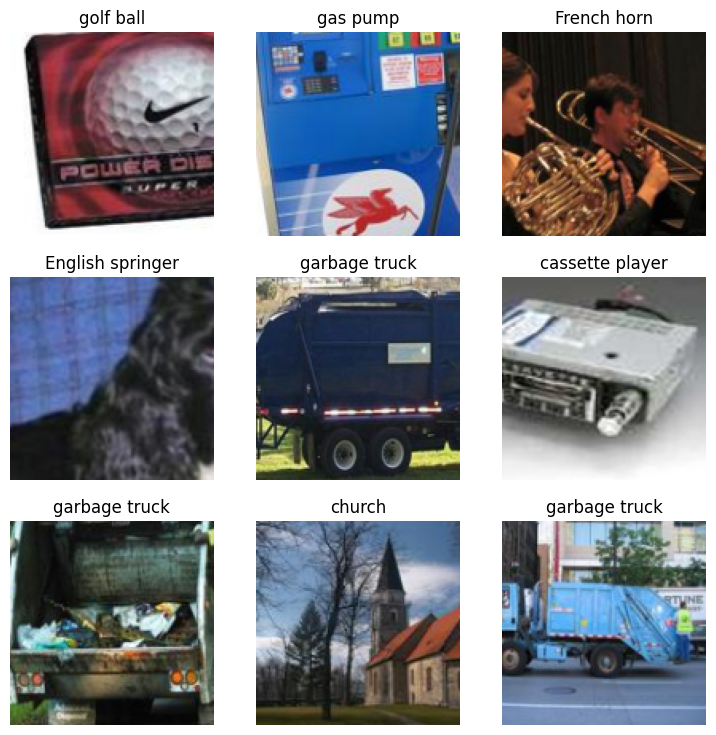

In [6]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

dls = imagenette.dataloaders(path, bs=64)
dls.show_batch()

### Training Code

I chose to run everything on a Colab Pro A100 GPU to maximize speed.

#### xse_resnext50

SuggestedLRs(valley=0.0004786300996784121)

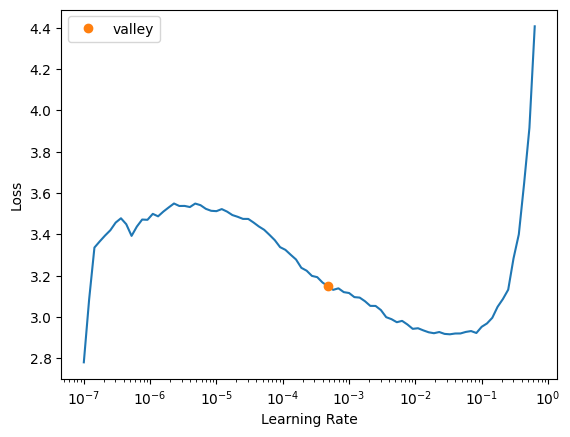

In [7]:
learn = vision_learner(dls, xse_resnext50, metrics=accuracy, pretrained=False)
learn.lr_find()

In [14]:
wandb.login()

True

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xse_resnext50-bs-64-lr-1e-4",
)

In [16]:
learn = vision_learner(dls, xse_resnext50, metrics=accuracy, pretrained=False, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.437292,1.562259,0.498599,00:15
1,1.898073,1.330338,0.581401,00:15
2,1.625788,1.184957,0.630828,00:15
3,1.491183,1.138762,0.650446,00:15
4,1.425214,1.119943,0.653248,00:15


In [29]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xse_resnext50-bs-64-lr-1e-3",
)

In [19]:
learn = vision_learner(dls, xse_resnext50, metrics=accuracy, pretrained=False, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.115490,1.610692,0.511592,00:15
1,1.563322,1.359540,0.592866,00:15
2,1.205948,1.041064,0.673631,00:15
3,0.988717,0.896793,0.712611,00:15
4,0.865071,0.776657,0.752611,00:15


In [21]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xse_resnext50-bs-64-lr-1e-2",
)

In [23]:
learn = vision_learner(dls, xse_resnext50, metrics=accuracy, pretrained=False, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.025805,4.565277,0.225478,00:15
1,1.586654,1.567472,0.527389,00:15
2,1.162438,0.994889,0.680255,00:15
3,0.868640,0.672154,0.780892,00:15
4,0.703673,0.635068,0.792611,00:15


In [ ]:
wandb.finish()

#### xresnet34

SuggestedLRs(valley=0.0005754399462603033)

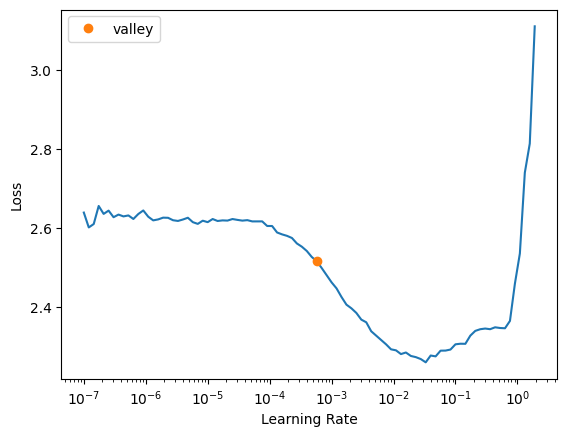

In [27]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)
learn.lr_find()

In [28]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet34-bs-64-lr-1e-4",
)

In [35]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.054720,1.864616,0.371975,00:09
1,1.605212,1.489624,0.525350,00:09
2,1.307533,1.235453,0.619618,00:09
3,1.180410,1.153767,0.642038,00:09
4,1.124177,1.139668,0.644586,00:09


In [37]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet34-bs-64-lr-1e-3",
)

In [39]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.607826,1.416133,0.538344,00:10
1,1.204550,1.263326,0.578853,00:09
2,0.946661,0.917620,0.710828,00:09
3,0.784756,0.758046,0.755414,00:09
4,0.683072,0.704371,0.777580,00:09


In [41]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet34-bs-64-lr-1e-2",
)

In [43]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.571024,2.439970,0.335541,00:09
1,1.255883,2.097694,0.395414,00:09
2,1.018229,0.989576,0.681529,00:09
3,0.785577,0.728265,0.762293,00:09
4,0.623264,0.640818,0.792866,00:09


In [45]:
wandb.finish()

#### xresnet18

SuggestedLRs(valley=0.0020892962347716093)

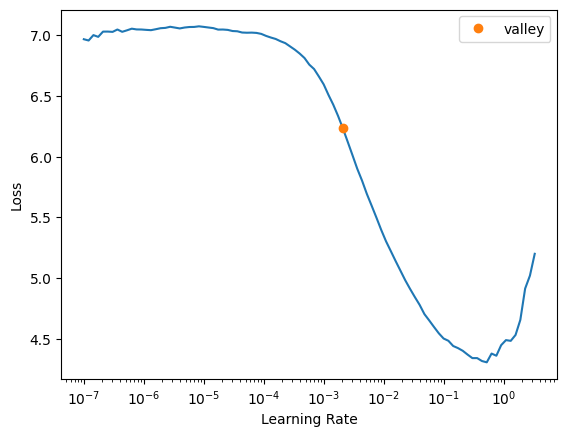

In [46]:
learn = Learner(dls, xresnet18(), metrics=accuracy)
learn.lr_find()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet18-bs-64-lr-1e-4",
)

In [48]:
learn = Learner(dls, xresnet18(), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,5.608559,4.292247,0.301147,00:07
1,2.270526,1.728192,0.505478,00:07
2,1.517185,1.401804,0.579108,00:07
3,1.327132,1.287121,0.610446,00:07
4,1.274527,1.265958,0.617070,00:07


In [50]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet18-bs-64-lr-1e-3",
)

In [52]:
learn = Learner(dls, xresnet18(), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.134495,1.742504,0.445860,00:07
1,1.249879,1.266531,0.584204,00:07
2,0.986120,1.082811,0.648153,00:07
3,0.804976,0.767623,0.758471,00:07
4,0.708721,0.734305,0.774267,00:07


In [54]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet18-bs-64-lr-1e-2",
)

In [56]:
learn = Learner(dls, xresnet18(), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.665481,2.706135,0.358726,00:07
1,1.278437,1.516189,0.505987,00:07
2,1.017887,1.038873,0.663440,00:07
3,0.801989,0.718528,0.761529,00:07
4,0.638737,0.650084,0.787006,00:07


In [59]:
wandb.finish()

In [ ]:
wandb.init(
    project="tinyscale-lab",
    name="imagenette-xresnet18-bs-64-lr-1e-1",
)

In [61]:
learn = Learner(dls, xresnet18(), metrics=accuracy, cbs=WandbCallback())
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.755140,2.272295,0.325860,00:07
1,1.501531,3.738475,0.322293,00:07
2,1.238407,1.375671,0.547516,00:07
3,1.036412,0.896265,0.707516,00:07
4,0.850425,0.815597,0.737325,00:07


In [64]:
wandb.finish()